In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../..')

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.transformation.MagneticFields import MagneticFields   
from magrec.transformation.Bsensor2Mxy import Bsensor2Mxy   
from magrec.misc.data import Data
from magrec import __datapath__


import magrec.image_processing.Masks as Masks
from magrec.method.FCNN import FCNN
from magrec.models.UniformMagnetisation import UniformMagnetisation

Applied a high frequency filter, removing all components smaller than 0.5 um


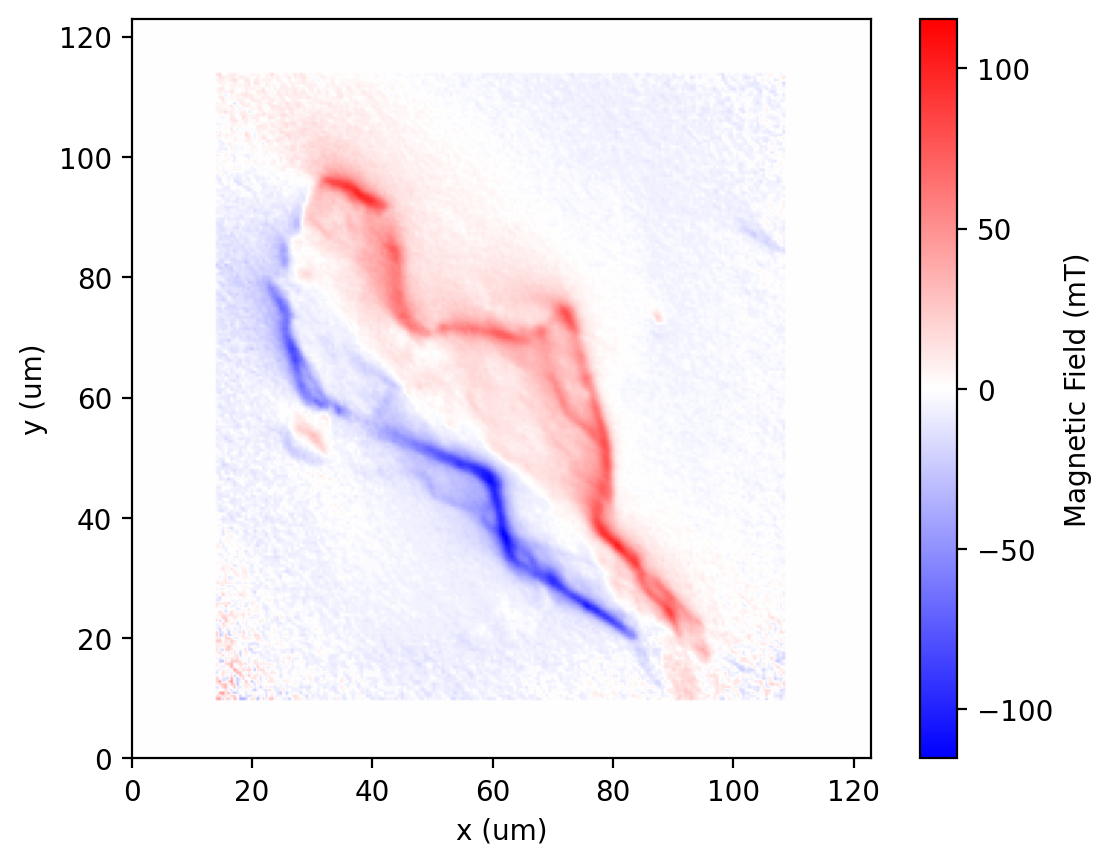

In [4]:
f = open(__datapath__ / "experimental" / "Magnetisation in plane" / "CuCrP2S6_unimelb_measurement_72_Bnv.json")
data = json.load(f)

BNV = data["ExperimentMagneticField"]['BNV']["Data"]
Bz = np.array(data["ExperimentMagneticField"]['Bz']) * 1e3
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6  # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] * 1e6

# dataset.define_pixel_size(dx, dy)

sensor_theta = 0
sensor_phi = 0

height = 0.1
thickness = 0.01

dataset = Data()
dataset.load_data(Bz, dx, dy, height, sensor_theta, sensor_phi, thickness)

dataset.remove_DC_background()
# Add filter 
dataset.add_hanning_filter(0.5)
dataset.add_short_wavelength_filter(0.5)
dataset.pad_data_to_power_of_two()

dataset.plot_target()

Applied a high frequency filter, removing all components smaller than 0.1 um


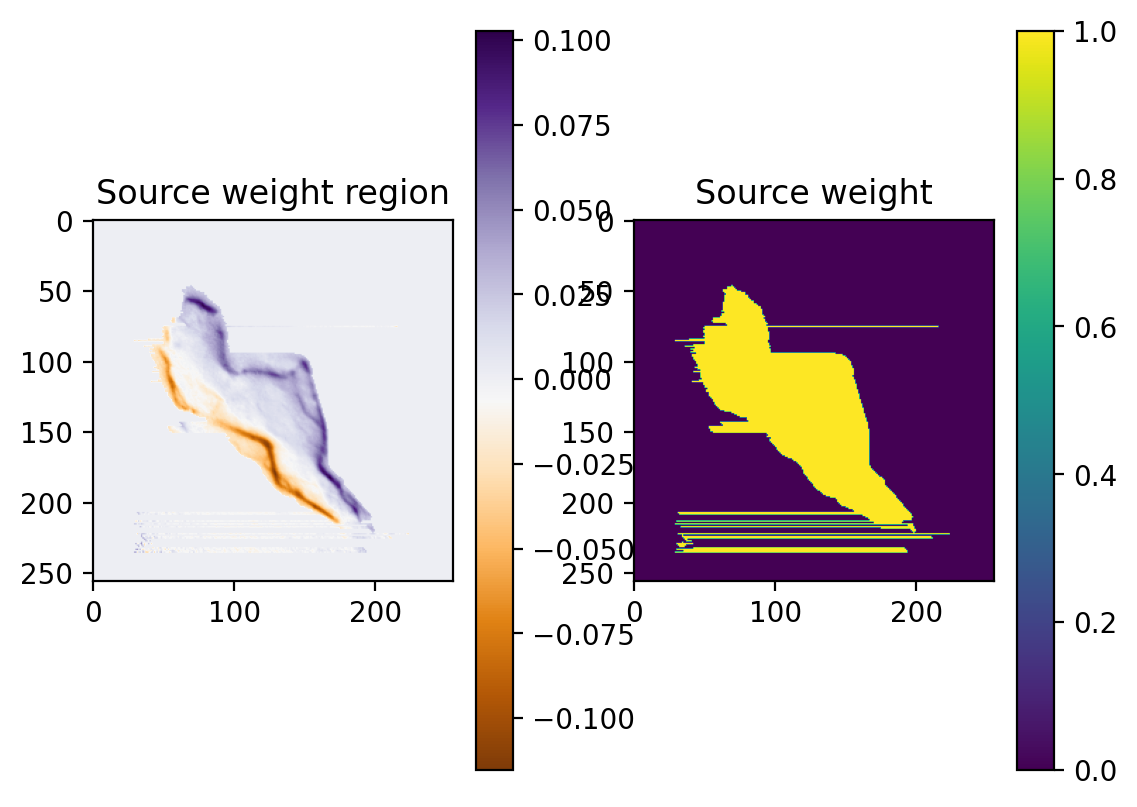

In [15]:
source_wieght = Masks.mask_hor_dir(dataset.target, 2.2e-2)


Model = UniformMagnetisation(dataset, "MSE", 
                             m_theta = 85, 
                             m_phi = 46 +90,
                             fit_m_theta = False, 
                             fit_m_phi = True,
                             scaling_factor = 1e6, 
                             std_loss_scaling = 0, 
                             loss_weight = None,
                             source_weight = source_wieght,
                             spatial_filter = False,
                             spatial_filter_width = 0.1)


Model.plot_weights()


## Now we will try to reconstruct the magnetisation using a neural network.

Number of sources: 1
Number of targets: 1
epoch     1 | loss on last mini-batch:  2.15e+08
epoch    11 | loss on last mini-batch:  2.15e+08
epoch    21 | loss on last mini-batch:  2.15e+08
epoch    31 | loss on last mini-batch:  2.15e+08
epoch    41 | loss on last mini-batch:  2.14e+08
epoch    51 | loss on last mini-batch:  2.01e+08
epoch    61 | loss on last mini-batch:  1.25e+08
epoch    71 | loss on last mini-batch:  7.31e+07
epoch    81 | loss on last mini-batch:  4.45e+07
epoch    91 | loss on last mini-batch:  2.49e+07
epoch   101 | loss on last mini-batch:  1.39e+07
epoch   111 | loss on last mini-batch:  8.37e+06
epoch   121 | loss on last mini-batch:  5.57e+06
epoch   131 | loss on last mini-batch:  4.05e+06
epoch   141 | loss on last mini-batch:  3.20e+06
epoch   151 | loss on last mini-batch:  2.69e+06
epoch   161 | loss on last mini-batch:  2.37e+06
epoch   171 | loss on last mini-batch:  2.15e+06
epoch   181 | loss on last mini-batch:  2.00e+06
epoch   191 | loss on last 

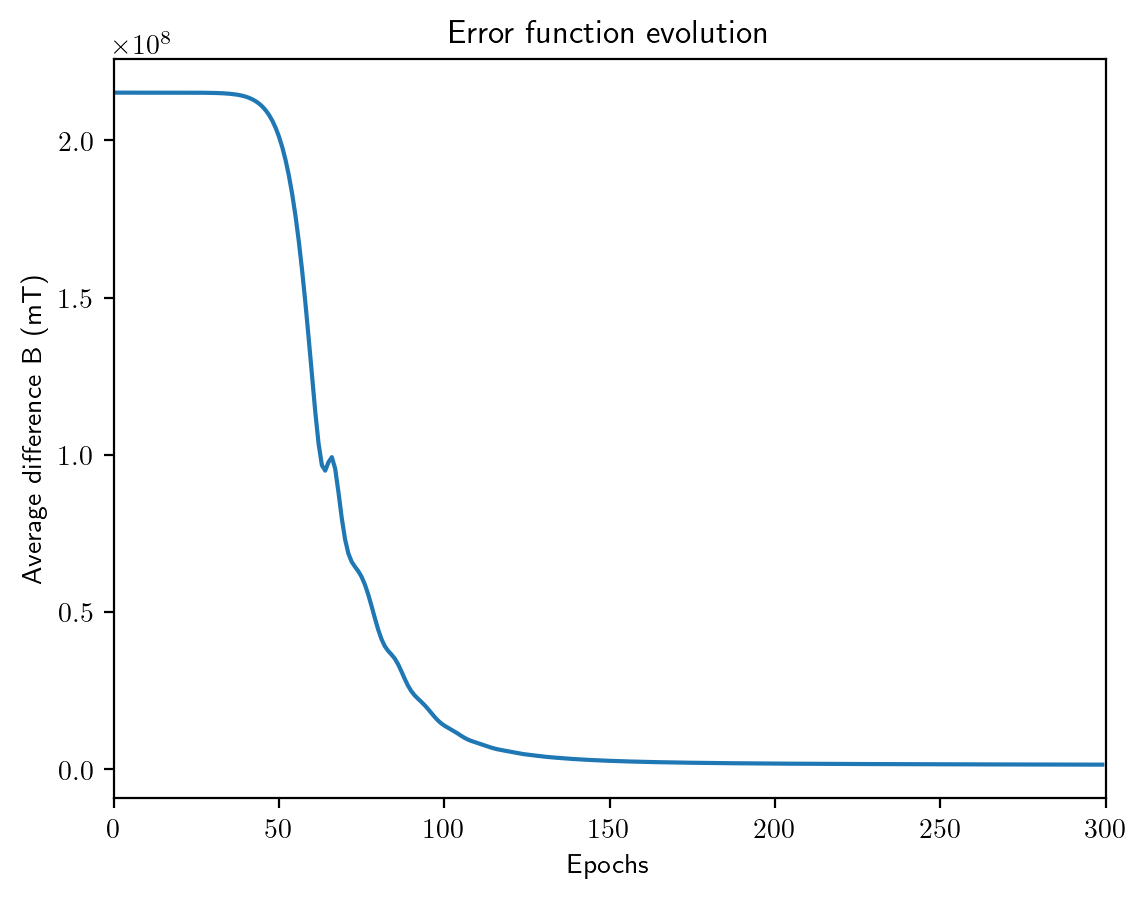

In [66]:

FittingMethod = FCNN(Model)
FittingMethod.fit(n_epochs=301)
FittingMethod.plot_loss()

Removed the padding that was applied to the data


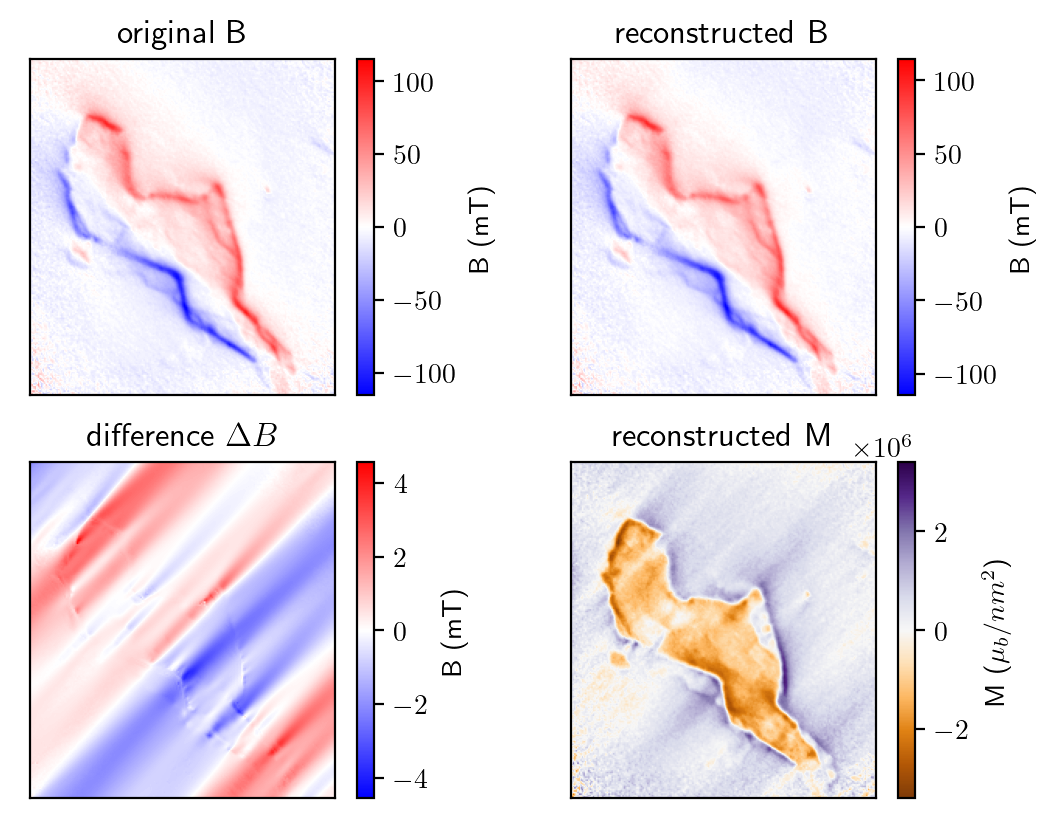

In [67]:
FittingMethod.extract_results()
FittingMethod.plot_results()